True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


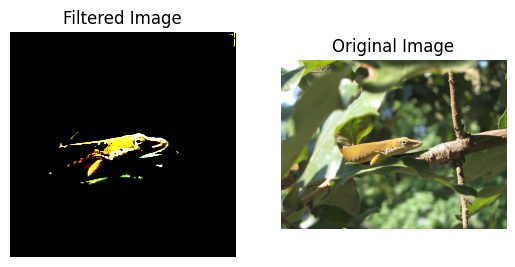

Predicted label: 818
Input label: tensor([40])



KeyboardInterrupt



In [2]:
from crp.helper import get_layer_names
from matplotlib import pyplot as plt
import torch
from torchvision.models.vgg import vgg16_bn
import torchvision.transforms as T
from PIL import Image, ImageOps
from zennit.composites import EpsilonPlusFlat
from zennit.canonizers import SequentialMergeBatchNorm
from crp.attribution import CondAttribution
from crp.concepts import ChannelConcept
from crp.image import imgify, vis_opaque_img
import torchvision.transforms as transforms
import torchvision
import numpy as np

# Define the input images and corresponding target labels
input_images = [
    "images/lizard.jpg",
    "images/cat.jpg",
    "images/dog.jpg",
    "images/bird.jpg",
    "images/elephant.jpg",
    "images/elephant2.jpg",
    "images/fox.jpg",
    "images/monkey.jpg",
    "images/panda.jpg",
    "images/pig.jpg",
    "images/rabbit.jpg",
    "images/wolf.jpg",
    "images/zebra.jpg",
]

for image_path in input_images:
    cc = ChannelConcept()

    # Define the mask function to mask channel 0 and 2 in batch 0
    mask_fn = cc.mask(0, [0, 2])

    mask_fn(torch.ones((2, 4, 2, 2)))

    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    # Load the pre-trained VGG16 model with batch normalization
    model = vgg16_bn(True).to(device)
    model.eval()

    composite = EpsilonPlusFlat([SequentialMergeBatchNorm()])
    attribution = CondAttribution(model, no_param_grad=True)

    transform = T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    # Load and preprocess the input image
    image = Image.open(image_path)
    sample = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        image_a = transform(image).unsqueeze(0)
        output_a = model(image_a)
    
    _, target_label = torch.max(output_a, 1)

    # Compute the heatmap with respect to the target label
    conditions = [{"y": target_label}]

    # Enable gradients for the input sample
    sample.requires_grad = True
    attr = attribution(sample, conditions, composite, mask_map=cc.mask)

    # Get the layer names for the convolutional and linear layers
    layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])

    # Create a mask map for all layers using the channel concept mask
    mask_map = {name: cc.mask for name in layer_names}

    attr = attribution(sample, conditions, composite, mask_map=mask_map)
    print(torch.equal(attr[0], attr.heatmap))

    # Convert the attribution heatmap to an image representation
    heatmap = imgify(attr.heatmap, symmetric=True)
    future = imgify(attr.heatmap, symmetric=True)

    # Apply grayscale method
    future = ImageOps.grayscale(future)

    # Invert the grayscale image
    future = ImageOps.invert(future)

    # Convert the PIL image to a heatmap tensor
    heatmap_tensor = torchvision.transforms.functional.pil_to_tensor(future)

    # Set a threshold to remove lower intensity values
    threshold = heatmap_tensor.flatten().double().std() + heatmap_tensor.flatten().double().mean() * 2

    def set_less_than_value_to_zero(tensor, value):
        mask = tensor < value
        tensor[mask] = 0

    set_less_than_value_to_zero(heatmap_tensor, threshold)

    # Convert the heatmap tensor to a binary mask
    mask = heatmap_tensor > 0

    # Apply the mask to the original image tensor to preserve the colors
    masked_image = transform(image)  *  mask.float()

    masked_image = masked_image.permute(1, 2, 0)
    plt.subplot(1, 2, 1)
    plt.imshow(masked_image)
    plt.title("Filtered Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.show()

    masked_image_pil = Image.fromarray(masked_image.numpy().astype(np.uint8))

    with torch.no_grad():
        image_b = transform(masked_image_pil).unsqueeze(0)
        output = model(image_b)


    # Get the predicted label
    _, predicted_idx = torch.max(output, 1)
    predicted_label = predicted_idx.item()

    # Print the predicted label
    print("Predicted label:", predicted_label)
    print("Input label:", target_label)

